In [2]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import statsmodels.api as sm

import random

import math

import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

from statsmodels.stats.outliers_influence import variance_inflation_factor

import os

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score


from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import r2_score

xl = pd.ExcelFile('../data/Tab_Compl_CNT_2T19.xls')
df = xl.parse("Série Encadeada",skiprows=2)
d = { 'Ano' : df['Período'], 'FBKF': df['Formação Bruta de Capital Fixo'] }

dfe = pd.DataFrame(d)
dfe_novo = dfe[dfe.Ano.str.contains(r'.', na=False)]
dfe_novo = dfe_novo[~dfe_novo.Ano.str.contains(r'Esta', na=False)]

dfe_novo[[ 'Ano','Trimestre']] = dfe_novo["Ano"].str.split(".", n = 1, expand = True)

dfe_novo["AnoCompleto"]= dfe_novo["Ano"].str.cat(dfe_novo["Trimestre"].copy() , sep =".")

dfe_novo = dfe_novo.dropna()

dfe_novo = dfe_novo.reset_index() ## Reordenando os indices (index)


N = np.size(dfe_novo.FBKF)


x = np.linspace(0.0, N, N)
X = np.arange(0, 94, 1);


4     103.373650
7     109.259266
15     98.710614
20    107.703831
22    108.103547
31    101.758205
33    108.508150
34    114.413053
37    111.814764
38    115.403166
39    111.900276
40    113.804237
42    122.045149
43    121.579972
46    139.411460
47    138.182191
49    148.011157
50    164.441152
51    145.820053
52    123.701347
58    182.226581
63    187.235308
67    188.374253
68    183.395752
72    191.022023
75    183.913355
76    173.022422
80    140.513491
82    143.497268
83    137.127000
87    142.129714
Name: FBKF, dtype: float64
[108.48906827 110.62651949 102.94311778 102.40737756 103.20461782
 102.90941854 102.72214363 102.97224131 105.77029862 107.48003001
 109.57680646 112.03045011 117.80771989 121.00335538 130.98982422
 134.25391655 140.46785162 143.40517115 146.25004888 149.03650836
 167.06175804 185.46096576 197.43635249 199.22189453 190.12318072
 175.04144246 169.48193816 148.97730124 141.90851861 139.53681478
 137.83359964]
                            OLS Reg

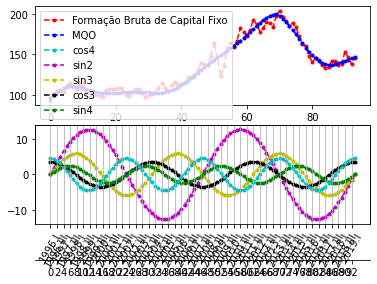

In [3]:

P0029 = np.zeros(N); P0029[00:N] = np.arange(0, N, 1); # P0029[0:29] = 1

P7085 = np.zeros(N); P7085[70:N] = np.arange(1, N-70+1, 1); #P2948[29:48] = 1

comparacaoHarm = pd.DataFrame()

StrnumHarm = ['const', 'P96.I', 'P98.II', 'P03.II', 'P09.I','P13.III', 'P17.II', 'sin1', 'cos1']
StrnumHarm = ['const', 'P96.I', 'P13.III', 'sin1', 'cos1']

acc_score = []

kf = KFold(n_splits=3,shuffle=True, random_state=2)

#results.params[results.pvalues<0.05]

#acc_score.append(accuracy_score(predictions, y_test))

#np.mean(acc_score)

numHarm=7
for numHarm in range(3,32):
#    ar_X = np.column_stack((np.ones(N), P0029, P1029, P2948, P4870, P7085, P8593, np.sin( 2.0 * np.pi * x/N), np.cos( 2.0 * np.pi * x/N)))
    ar_X = np.column_stack((np.ones(N), P0029, P7085, np.sin( 2.0 * np.pi * x/N), np.cos( 2.0 * np.pi * x/N)))
#    StrnumHarm = ['const', 'P96.I', 'P98.II', 'P03.II', 'P09.I','P13.III', 'P17.II', 'sin1', 'cos1']
    StrnumHarm = ['const', 'P96.I', 'P13.III', 'sin1', 'cos1']
    for i in range(2,numHarm):
        y = ((np.sin( i * 2.0*np.pi*x/N))).reshape(N,1)
        StrnumHarm.append('sin' + str(i))
        ar_X = np.hstack((ar_X, y))
        y = ((np.cos( i * 2.0*np.pi*x/N))).reshape(N,1)
        StrnumHarm.append('cos' + str(i))
        ar_X = np.hstack((ar_X, y))
        

    for train_index, test_index in kf.split(ar_X, dfe_novo.FBKF):
        X_train, X_test = ar_X[train_index], ar_X[test_index]
        y_train, y_test = dfe_novo.FBKF[train_index], dfe_novo.FBKF[test_index]

    model = sm.OLS( y_train, X_train)
    results = model.fit()
    predictions = results.predict(X_test)

#    model = sm.OLS( dfe_novo.FBKF, ar_X)
#    results = model.fit()

    if (numHarm == 5):
        print(y_test)
        print(predictions)

        print(results.summary(xname=StrnumHarm))
        Melhormodel = model # sm.OLS( dfe_novo.FBKF, ar_X)
        Melhorresults = Melhormodel.fit()
        Melhorar_X = ar_X
        
        print(Melhorresults.params[Melhorresults.pvalues<0.05])

        print(Melhorresults.summary(xname=StrnumHarm))

    #
    result = adfuller(results.resid)
    #print('ADF Statistic: %f' % result[0])
    #print('p-value: %f' % result[1])
    #for key, value in result[4].items():
    #	print('\t%s: %.3f' % (key, value))
    #
    #if ( result[1] > 0.05 ):
    #	print('Residual is NOT Stationary')

    if (explained_variance_score(y_test, predictions) > 0.7):
        comparacaoHarm[numHarm] = np.array ( [numHarm, sum(results.pvalues < 0.05), results.fvalue, results.rsquared, result[1]<0.05, explained_variance_score(y_test, predictions),  mean_absolute_error(predictions, y_test), r2_score(y_test, predictions)   ])
        #    comparacaoHarm[numHarm] = np.array ( [numHarm, sum(results.pvalues < 0.05), results.fvalue, results.rsquared, result[1]<0.05, explained_variance_score(y_test, predictions),  mean_absolute_error(predictions, y_test), r2_score(y_test, predictions)   ])

#    comparacaoHarm[numHarm] = np.array ( [numHarm, sum(results.pvalues < 0.05), results.fvalue, results.rsquared, result[1]<0.05])

comparacaoHarm = comparacaoHarm.T

comparacaoHarm.columns=['Qtd Harmônicos','Qtd Coef. Significantes 5%','Estatistica F','R^2','Residuous Normais', 'Variância Explicada', 'Erro médio absoluto', 'R2']
comparacaoHarm.reset_index()

#print(comparacaoHarm.sort_values(by=['Variância Explicada']))


print(comparacaoHarm.sort_values(by=['Estatistica F','Qtd Coef. Significantes 5%'],ascending=False))     


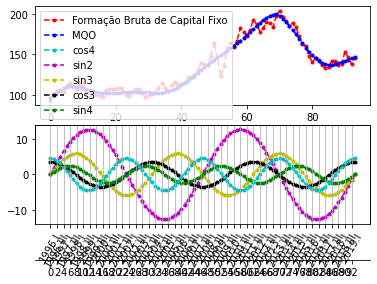

In [4]:

fig, (ax1, ax2) = plt.subplots(2)

#ax3.plot(np.array(y_test))
#ax3.plot(predictions)

plt.xticks(dfe_novo.index, dfe_novo.AnoCompleto, rotation=60, fontsize='x-small')
plt.xticks(dfe_novo.index[::2], dfe_novo.AnoCompleto[::2], rotation=60, size=10)

axx = ax2.twiny()

lns1 = ax1.plot(dfe_novo.index, dfe_novo.FBKF, 'r--.', label="Formação Bruta de Capital Fixo")

lns2 = ax1.plot(dfe_novo.index, Melhorresults.predict(Melhorar_X)  , 'b--.', label="MQO")

lns5 = ax2.plot(dfe_novo.index,   12.6103 * np.sin( 2 * 2.0 * np.pi * x/N) , 'm--.', label="sin2")
#
lns6 = ax2.plot(dfe_novo.index,    5.8710 * np.sin( 3 * 2.0 * np.pi * x/N) , 'y--.', label="sin3")
#
lns7 = ax2.plot(dfe_novo.index,    3.4990 * np.cos( 3 * 2.0 * np.pi * x/N) , 'k--.', label="cos3")

lns8 = ax2.plot(dfe_novo.index,    2.4136 * np.sin( 4 * 2.0 * np.pi * x/N) , 'g--.', label="sin4")

lns4 = ax2.plot(dfe_novo.index,    4.5207 * np.cos( 4 * 2.0 * np.pi * x/N) , 'c--.', label="cos4")

#lns3 = ax2.plot(dfe_novo.index,    3.4601 * np.cos( 5 * 2.0 * np.pi * x/N) , 'g--.', label="cos5")

lns = lns1+lns2+lns4+lns5+lns6+lns7+lns8
labs = [l.get_label() for l in lns]

axx.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom

axx.spines['bottom'].set_position(('outward', 36))

axx.xaxis.set_ticks(np.arange(0, 93, 2))

axx.set_xlim(ax1.get_xlim())

ax1.legend(lns, labs, loc='upper left')

plt.grid()

plt.show(block=False)


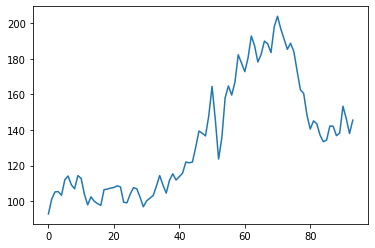

In [5]:
plt.plot(dfe_novo.FBKF)

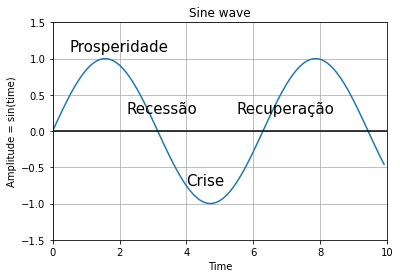

In [23]:
import numpy as np

import matplotlib.pyplot as plot

 

# Get x values of the sine wave

time        = np.arange(0, 10, 0.1);

 

# Amplitude of the sine wave is sine of a variable like time

amplitude   = np.sin(time)

 

# Plot a sine wave using time and amplitude obtained for the sine wave

plot.plot(time, amplitude)

 

# Give a title for the sine wave plot

plot.title('Sine wave')

 

# Give x axis label for the sine wave plot

plot.xlabel('Time')
plt.text(5.5, 0.25, 'Recuperação', fontsize=15)
plt.text(4, -0.75, 'Crise', fontsize=15)
plt.text(0.5, 1.1, 'Prosperidade', fontsize=15)
plt.text(2.2, 0.25, 'Recessão', fontsize=15)

plt.ylim(-1.5, 1.5)

plt.xlim(0, 10)

# Give y axis label for the sine wave plot

plot.ylabel('Amplitude = sin(time)')

 

plot.grid(True, which='both')

 

plot.axhline(y=0, color='k')

 

plot.show()

 

# Display the sine wave

plot.show()